In [ ]:
import os
import random
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import shutil

In [ ]:
# ================== CONFIG ==================
from google.colab import drive
drive.mount('/content/drive')

# Install pv for progress visualization
!apt-get -qq install unrar pv

# Create target directory
!mkdir -p /content/tid2013

# Extract with progress bar (quiet mode for unrar, pv shows progress)
!unrar x -y -idq "/content/drive/MyDrive/Samsung_Datasets/tid2013.rar" /content/tid2013/ | pv -l >/dev/null

DATASET_PATH = "/content/tid2013"
REF_PATH = os.path.join(DATASET_PATH, "reference_images")
DIST_PATH = os.path.join(DATASET_PATH, "distorted_images")
MOS_FILE = os.path.join(DATASET_PATH, "mos_with_names.txt")
OUTPUT_PATH = "/content/tid2013_patches"
PATCHES_DIR = os.path.join(OUTPUT_PATH, "patches")

NUM_SAMPLES = 1000
PATCH_SIZE = 20
CENTER_SIZE = 12
ALPHA = 0.5

os.makedirs(PATCHES_DIR, exist_ok=True)

!du -sh /content/tid2013

Mounted at /content/drive
Selecting previously unselected package pv.
(Reading database ... 126380 files and directories currently installed.)
Preparing to unpack .../pv_1.6.6-1build2_amd64.deb ...
Unpacking pv (1.6.6-1build2) ...
Setting up pv (1.6.6-1build2) ...
Processing triggers for man-db (2.10.2-1) ...
0.00  0:00:35 [0.00 /s] [<=>                                                   ]
1.7G	/content/tid2013


In [ ]:
# ================== LOAD MOS ==================
def load_mos_with_names(mos_file):
    mos_dict = {}
    with open(mos_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                # check if first token is a number or a filename
                if parts[0].lower().endswith('.bmp'):
                    fname, score = parts
                else:
                    score, fname = parts
                mos_dict[fname] = float(score)
    return mos_dict


In [ ]:
# ================== HELPERS ==================
def compute_psnr(img1, img2):
    arr1, arr2 = np.array(img1, dtype=np.float32), np.array(img2, dtype=np.float32)
    mse = np.mean((arr1 - arr2) ** 2)
    if mse == 0:
        return float("inf")
    return 10 * np.log10((255 ** 2) / mse)

def extract_patch(img, x, y, size=20):
    return img.crop((x, y, x + size, y + size))

def fuse_patch(clean_patch, dist_patch, mode="copy", alpha=0.5):
    clean_arr = np.array(clean_patch).astype(np.float32)
    dist_arr = np.array(dist_patch).astype(np.float32)
    h, w, _ = clean_arr.shape
    cx, cy = w // 2, h // 2
    half = CENTER_SIZE // 2
    x1, y1 = cx - half, cy - half
    x2, y2 = x1 + CENTER_SIZE, y1 + CENTER_SIZE

    fused = dist_arr.copy()
    if mode == "copy":
        fused[y1:y2, x1:x2] = clean_arr[y1:y2, x1:x2]
    else:  # blend
        fused[y1:y2, x1:x2] = alpha * clean_arr[y1:y2, x1:x2] + (1 - alpha) * dist_arr[y1:y2, x1:x2]

    return Image.fromarray(np.uint8(fused))

In [ ]:
# ================== LOAD AND SELECT FILES ==================
mos_dict = load_mos_with_names(MOS_FILE)
all_files = list(mos_dict.keys())

# shuffle for randomness
random.shuffle(all_files)

# pick N distorted images
selected_files = all_files[:NUM_SAMPLES]

print(f"Loaded {len(mos_dict)} MOS entries")
print(f"Selected {len(selected_files)} files for patch extraction")
print("First few examples:", selected_files[:5])


Loaded 3000 MOS entries
Selected 1000 files for patch extraction
First few examples: ['i21_18_4.bmp', 'i04_23_4.bmp', 'i03_14_2.bmp', 'i20_01_2.bmp', 'i09_19_4.bmp']


In [ ]:
print("Reference sample:", os.listdir(REF_PATH)[:5])
print("Distorted sample:", os.listdir(DIST_PATH)[:5])

Reference sample: ['I07.BMP', 'I11.BMP', 'I05.BMP', 'I20.BMP', 'I19.BMP']
Distorted sample: ['i06_21_2.bmp', 'i10_23_4.bmp', 'i02_19_2.bmp', 'i12_04_2.bmp', 'i25_12_1.bmp']


**Reference images are Uppercase while Distorted images are Lowercase.**

In [ ]:
refs = sorted(os.listdir(REF_PATH))
print("Reference images found:", refs)
print("Count:", len(refs))

Reference images found: ['I01.BMP', 'I02.BMP', 'I03.BMP', 'I04.BMP', 'I05.BMP', 'I06.BMP', 'I07.BMP', 'I08.BMP', 'I09.BMP', 'I10.BMP', 'I11.BMP', 'I12.BMP', 'I13.BMP', 'I14.BMP', 'I15.BMP', 'I16.BMP', 'I17.BMP', 'I18.BMP', 'I19.BMP', 'I20.BMP', 'I21.BMP', 'I22.BMP', 'I23.BMP', 'I24.BMP', 'i25.bmp']
Count: 25


**The last image file 'i25.BMP' is not Uppercase like the rest - rename it to match:**

In [ ]:
mv /content/tid2013/reference_images/i25.bmp /content/tid2013/reference_images/I25.BMP

In [ ]:
# ================== MAIN LOOP ==================
import random # Added import for random
metadata = []
psnr_values = []
dist_psnr_values = [] # List to store PSNR of distorted images

DATASET_NAME = "TID2013"

# Iterate 2000 times to generate 2000 patches
for idx in range(2000):
    # Select a random file from the selected files
    fname = random.choice(selected_files)

    # Parse distorted filename
    parts = fname.lower().split("_")
    if len(parts) < 3:
        print(f"Skipping {fname}, invalid filename format")
        continue

    ref_id = parts[0].upper()
    distortion_type = parts[1]
    distortion_level = parts[2].split(".")[0]

    # ----- Reference lookup -----
    clean_file = None
    for ext in [".BMP", ".bmp", ".PNG", ".png"]:
        candidate = os.path.join(REF_PATH, f"{ref_id}{ext}")
        if os.path.exists(candidate):
            clean_file = candidate
            break
    if clean_file is None:
        print(f"Skipping {fname}, reference not found")
        continue

    # ----- Distorted lookup -----
    dist_file = None
    for ext in [".BMP", ".bmp", ".PNG", ".png"]:
        candidate = os.path.join(DIST_PATH, os.path.splitext(fname)[0] + ext)
        if os.path.exists(candidate):
            dist_file = candidate
            break
    if dist_file is None:
        print(f"Skipping {fname}, distorted not found")
        continue

    # ----- Load images -----
    clean_img = Image.open(clean_file).convert("RGB")
    dist_img = Image.open(dist_file).convert("RGB")

    # Calculate PSNR of the distorted image relative to the clean image
    dist_psnr = compute_psnr(clean_img, dist_img)
    dist_psnr_values.append(dist_psnr)

    w, h = clean_img.size

    # Random coords
    x = random.randint(0, w - PATCH_SIZE)
    y = random.randint(0, h - PATCH_SIZE)

    clean_patch = extract_patch(clean_img, x, y, PATCH_SIZE)
    dist_patch = extract_patch(dist_img, x, y, PATCH_SIZE)

    # ----- Generate ref patches (copy fusion) -----
    fusion_mode = "copy"
    method_label = "copy"

    fused_patch = fuse_patch(clean_patch, dist_patch, mode=fusion_mode, alpha=ALPHA)
    psnr = compute_psnr(clean_patch, fused_patch)
    psnr_values.append(psnr)

    # Use the loop index for the output filename
    out_name = f"{method_label}_patch_{idx:04}.png"
    fused_patch.save(os.path.join(PATCHES_DIR, out_name))

    # Get MOS
    mos_score = mos_dict.get(fname)
    if mos_score is None:
        continue
    normalized_score = round(mos_score / 9, 3)

    # Bin MOS → color and score
    if normalized_score >= 0.66:
        color = "GREEN"
        binned_score = 1
    elif normalized_score >= 0.33:
        color = "ORANGE"
        binned_score = 0.5
    else:
        color = "RED"
        binned_score = 0

    dist_id  = os.path.splitext(os.path.basename(dist_file))[0]
    # Update unique_sample_id to be the patch filename
    uid = out_name

    # Build metadata entry
    metadata.append({
      "unique_sample_id": uid,          # canonical id
      "clean_image": os.path.basename(clean_file),
      "distorted_image": os.path.basename(dist_file),
      "score": float(normalized_score), # [0..1], 1 = more different
      "metadata": {
        "method": method_label,
        "image_source": DATASET_NAME,
        "bp_case": f"case{distortion_type}",
        "color": color,
        "score_binned": binned_score,
        "IQE_workspace_number": 990,
        "mos_original": mos_score,
        "mos_normalized": normalized_score,
        "roi": [x, y, PATCH_SIZE, PATCH_SIZE],
        "crop_id": dist_id,
        "distorted_psnr": dist_psnr # Store PSNR of distorted image
      }
    })

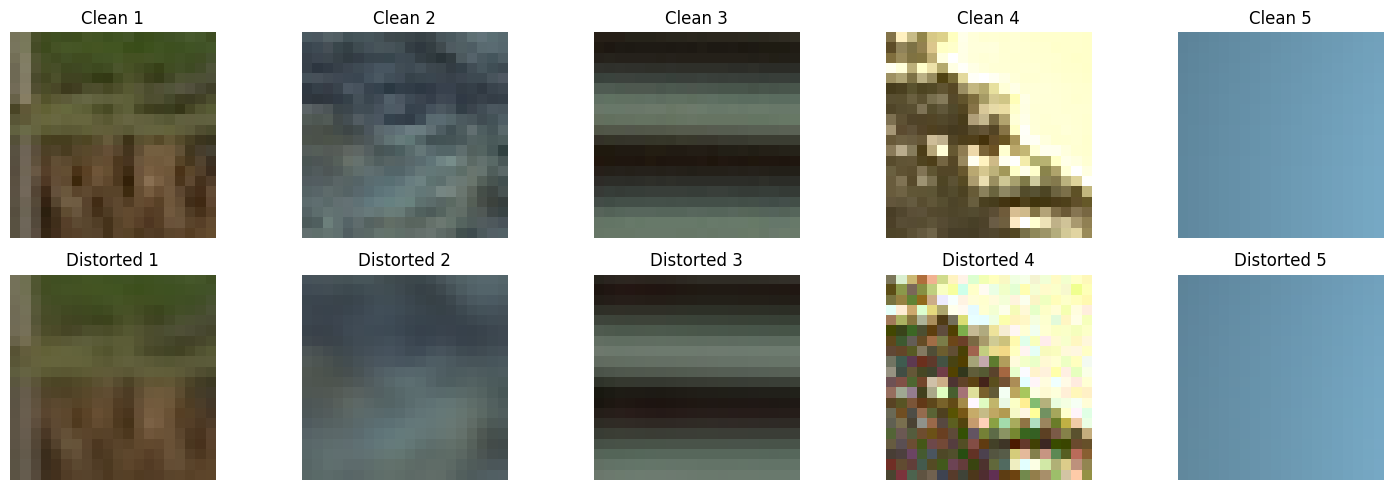

In [ ]:
# ================== DISPLAY FIRST 5 PATCHES ==================
def display_first_patches(num_samples=5):
    # Assuming the patches are named sequentially like "copy_patch_0000.png", "copy_patch_0001.png", etc.
    # and the metadata list is in the same order
    if not metadata:
        print("Metadata is empty. Please run the patch generation cell first.")
        return

    plt.figure(figsize=(15, 5))
    for i in range(min(num_samples, len(metadata))):
        metadata_entry = metadata[i]

        clean_img_name = metadata_entry["clean_image"]
        dist_img_name = metadata_entry["distorted_image"]
        x, y, _, _ = metadata_entry["metadata"]["roi"]

        # Load original clean and distorted images
        clean_img_path = os.path.join(REF_PATH, clean_img_name)
        dist_img_path = os.path.join(DIST_PATH, dist_img_name)

        if os.path.exists(clean_img_path) and os.path.exists(dist_img_path):
            clean_img = Image.open(clean_img_path).convert("RGB")
            dist_img = Image.open(dist_img_path).convert("RGB")

            # Extract patches using the saved coordinates
            clean_patch = extract_patch(clean_img, x, y, PATCH_SIZE)
            dist_patch = extract_patch(dist_img, x, y, PATCH_SIZE)

            # Display clean patch
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(clean_patch)
            plt.title(f"Clean {i+1}")
            plt.axis("off")

            # Display distorted patch
            plt.subplot(2, num_samples, i + num_samples + 1)
            plt.imshow(dist_patch)
            plt.title(f"Distorted {i+1}")
            plt.axis("off")
        else:
            print(f"Original images not found for metadata entry {i}")

    plt.tight_layout()
    plt.show()

display_first_patches(5)

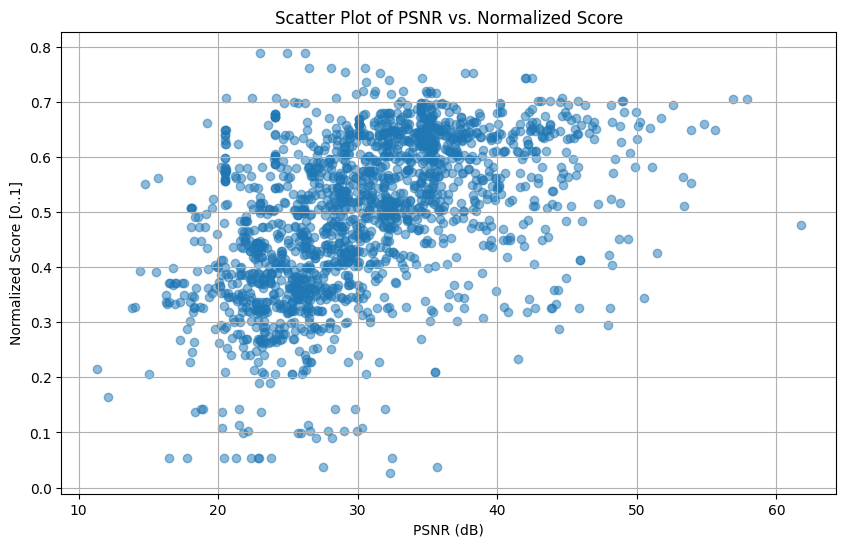

In [ ]:
# ================== DISPLAY PSNR VS. NORMALIZED SCORE SCATTER PLOT ==================

# Extract normalized scores from metadata, ensuring it aligns with psnr_values
# Assuming metadata and psnr_values lists are in the same order
normalized_scores = [entry["score"] for entry in metadata]

plt.figure(figsize=(10, 6))
plt.scatter(psnr_values, normalized_scores, alpha=0.5)
plt.xlabel("PSNR (dB)")
plt.ylabel("Normalized Score [0..1]")
plt.title("Scatter Plot of PSNR vs. Normalized Score")
plt.grid(True)
plt.show()

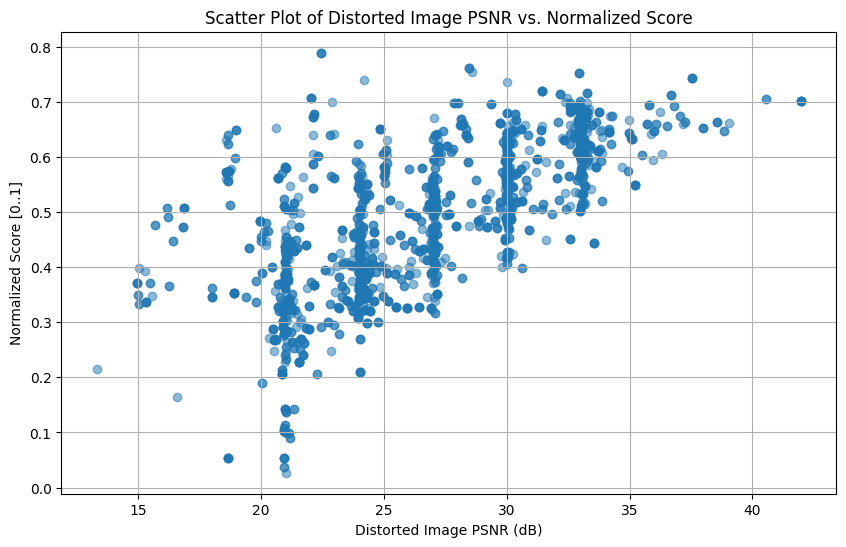

In [ ]:
# ================== DISPLAY DISTORTED IMAGE PSNR VS. NORMALIZED SCORE SCATTER PLOT ==================

# Extract distorted PSNR and normalized scores from metadata
distorted_psnr_values = [entry["metadata"]["distorted_psnr"] for entry in metadata]
normalized_scores = [entry["score"] for entry in metadata]

plt.figure(figsize=(10, 6))
plt.scatter(distorted_psnr_values, normalized_scores, alpha=0.5)
plt.xlabel("Distorted Image PSNR (dB)")
plt.ylabel("Normalized Score [0..1]")
plt.title("Scatter Plot of Distorted Image PSNR vs. Normalized Score")
plt.grid(True)
plt.show()

In [ ]:
# ================== SAVE RESULTS ==================
def convert_floats(obj):
    if isinstance(obj, np.float32):
        return float(obj)
    if isinstance(obj, dict):
        return {k: convert_floats(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [convert_floats(elem) for elem in obj]
    return obj

metadata_serializable = convert_floats(metadata)

with open(os.path.join(OUTPUT_PATH, "metadata.json"), "w") as f:
    json.dump(metadata_serializable, f, indent=2)

plt.hist([p for p in psnr_values if p != float("inf")], bins=30)
plt.xlabel("PSNR (dB)")
plt.ylabel("Frequency")
plt.title("Histogram of PSNR values")
plt.savefig(os.path.join(OUTPUT_PATH, "psnr_histogram.png"))
plt.close()

In [ ]:
# !zip -qr tid2013_patches.zip tid2013_patches
# files.download("tid2013_patches.zip")

In [ ]:
# ================== SAVE RESULTS ==================

# Your Drive target (same as before)
drive_save_dir = "/content/drive/MyDrive/Samsung_Project/tid2013_patches"
os.makedirs(drive_save_dir, exist_ok=True)

# Ensure subfolders (only copy)
copy_dir = os.path.join(drive_save_dir, "copy")
os.makedirs(copy_dir, exist_ok=True)

def is_image(path):
    return os.path.splitext(path)[1].lower() in {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp"}

def route(fname_lower):
    # Only route to copy_dir for image files that should go there
    if is_image(fname_lower) and (fname_lower.startswith("copy_") or "copy_patch_" in fname_lower or "clean" in fname_lower or "reference" in fname_lower):
        return copy_dir
    return None # Don't route other image files

# Move/copy all files from /content/tid2013_patches
src_root = "/content/tid2013_patches"
moved_copy = 0
non_images = 0

for root, _, files in os.walk(src_root):
    for fname in files:
        src = os.path.join(root, fname)
        low = fname.lower()
        if is_image(src):
            dst_dir = route(low)
            if dst_dir: # Only copy if a valid destination directory is found
                dst = os.path.join(dst_dir, fname)
                os.makedirs(os.path.dirname(dst), exist_ok=True)
                shutil.copy2(src, dst)
                moved_copy += 1
        else:
            # Save any non-image file (JSON, histogram, CSV, etc.) in main folder
            dst = os.path.join(drive_save_dir, fname)
            shutil.copy2(src, dst)
            non_images += 1

print(f"Saved patches to: {drive_save_dir}")
print(f"Images -> copy/: {moved_copy}, other files: {non_images}")
print("Sample copy/:", sorted(os.listdir(copy_dir))[:5])
print("Other files in main folder:", [f for f in os.listdir(drive_save_dir) if os.path.isfile(os.path.join(drive_save_dir, f))])
shutil.copy2(os.path.join(OUTPUT_PATH, "psnr_histogram.png"), "/content/drive/MyDrive/Samsung_Project/tid2013_patches/")

Saved patches to: /content/drive/MyDrive/Samsung_Project/tid2013_patches
Images -> copy/: 2000, other files: 1
Sample copy/: ['copy_patch_0000.png', 'copy_patch_0001.png', 'copy_patch_0002.png', 'copy_patch_0003.png', 'copy_patch_0004.png']
Other files in main folder: ['psnr_histogram.png', 'metadata.json', 'test.json', 'train.json']


'/content/drive/MyDrive/Samsung_Project/tid2013_patches/psnr_histogram.png'